# Demo of SCOD with a simple 2D dataset

In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange

from matplotlib import pyplot as plt

First, define the dataset

In [2]:
class TwoDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x1 = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])
        x2 = -1 + 2*np.random.rand(N)
        x = np.stack([x1,x2],axis=-1)
        y = fn(x.sum(-1))
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

class UniformDataset(torch.utils.data.Dataset):
    def __init__(self, N=500) -> None:
        super().__init__()

        x = -3 + 6*np.random.rand(N*2).reshape([N,2])
        y = x[:,0]
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])


Next, we create a model (simple MLP), and train it to fit this data

In [3]:
# DNN mapping 2d input to 1d distribution parameter
model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 1)
)

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Normal(loc=theta, scale=0.2)

### train a base DNN model

mean_loss=-0.671484: 100%|██████████| 50/50 [00:00<00:00, 93.47it/s]


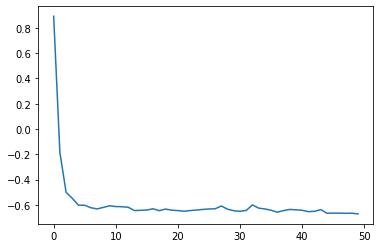

In [4]:
dataset = TwoDDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses = []
t = trange(50)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

Visualize the simple trained DNN

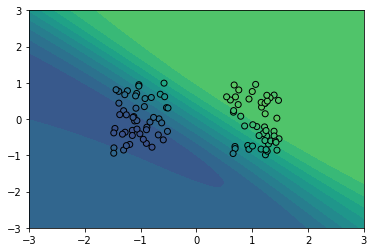

In [92]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

plt.contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
plt.scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')

### Applying SCOD
Now, we apply SCOD to the network to add uncertainty estimation

In [82]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_parameter',
})

Weight space dimension: 8.577e+03


### process training dataset to compute posterior uncertainty

In [83]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


### use validation dataset to optimize prior variance

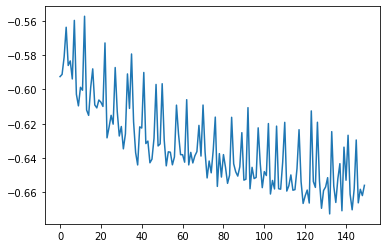

In [89]:
val_dataset = TwoDDataset(split='val')
unc_model.log_prior_scale.data *= 0
loss_curve = unc_model.optimize_prior_scale_by_nll(val_dataset, num_epochs=30)
plt.plot(loss_curve)

In [76]:
val_optim_prior = unc_model.log_prior_scale

## Using a GP to regularize SCOD

In [99]:
gp_reg_unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 8.577e+03


First, we optimize the prior scale to match a squared exponential GP

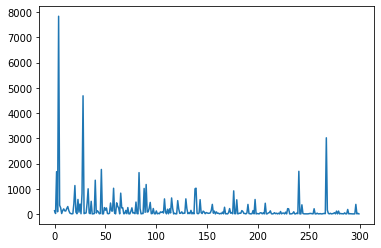

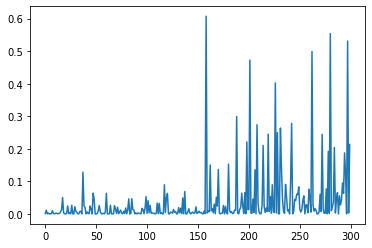

In [101]:
def GP_kernel(inputs):
    sq_dist = torch.norm( (inputs[:,None,:] - inputs[None,:,:]), dim=-1 )**2
    length_scale = 0.2
    kernel = torch.exp(- sq_dist / length_scale)
    return kernel

uniform_dataset = UniformDataset()
gp_reg_unc_model.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel, num_epochs=30, batch_size=10)
plt.plot(loss_curve)
plt.show()
plt.plot(1./np.array(min_eigs))

Now, we compute the GGN in the rescaled space:

In [102]:
gp_reg_unc_model.process_dataset(dataset)

computing basis
using T = 304


## Alternative GP:
Only count distance in y direction

In [103]:
gp_reg_unc_model_2 = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 8.577e+03


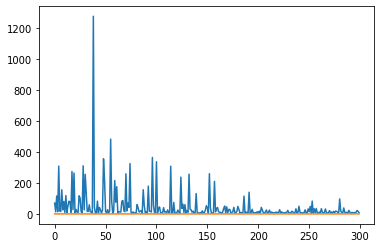

In [104]:
def GP_kernel_y_only(inputs):
    sq_dist = ( (inputs[:,None,1] - inputs[None,:,1])**2 )
    length_scale = 0.2
    kernel = torch.exp(- sq_dist / length_scale)
    return kernel

uniform_dataset = UniformDataset()
gp_reg_unc_model_2.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model_2.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel_y_only, num_epochs=30, batch_size=10)
plt.plot(loss_curve)
plt.plot(min_eigs)

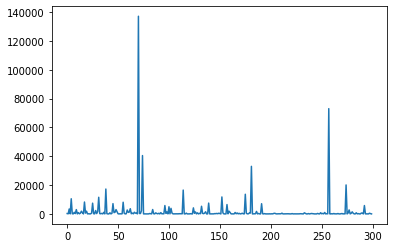

In [105]:
plt.plot(1./np.array(min_eigs))

In [106]:
gp_reg_unc_model_2.process_dataset(dataset)

computing basis
using T = 304



### compare SCOD's predictions to the original trained model

In [107]:
settings = [
    {   
        'name': 'Unit Prior',
        'model': unc_model,
        'prior_scales': 0*unc_model.log_prior_scale,
    },
    {   
        'name': 'Val Optimized Prior',
        'model': unc_model,
        'prior_scales': None,
    },
    {   
        'name': 'GP Optimized Prior',
        'model': gp_reg_unc_model,
        'prior_scales': None,
    },
    {   
        'name': 'GP Optimized Prior 2',
        'model': gp_reg_unc_model_2,
        'prior_scales': None,
    },
]

In [108]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

In [109]:
results = []
for setting in settings:
    scod_model = setting['model']
    old_prior_scales = scod_model.log_prior_scale.data + 0.
    if setting['prior_scales'] is not None:
        scod_model.log_prior_scale.data = setting['prior_scales']
    
    dists, _ = scod_model(xx_tensor)
    prior_dists, _ = scod_model(xx_tensor, use_prior=True)

    scod_model.log_prior_scale.data = old_prior_scales
    vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in dists] )
    prior_vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in prior_dists] )
    result = {
        'name': setting['name'],
        'vars': vars.reshape(X1.shape),
        'prior_vars': prior_vars.reshape(X1.shape)
    }
    results.append(result)

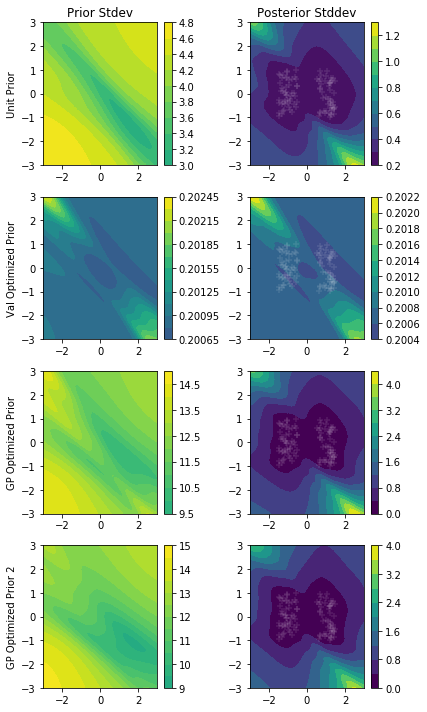

In [110]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,10])
for i, result in enumerate(results):
    m = axes[i,0].contourf(X1,X2,result['prior_vars'], vmin=0.2, levels=10)
    plt.colorbar(m, ax=axes[i,0])
    m = axes[i,1].contourf(X1,X2,result['vars'], vmin=0.2, levels=10)
    plt.colorbar(m, ax=axes[i,1])
    axes[i,1].scatter(dataset.X[:,0], dataset.X[:,1], marker='+', vmin=-2, vmax=2, color='white', alpha=0.1)

    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Stdev')
axes[0,1].set_title('Posterior Stddev')

plt.tight_layout()

In [75]:
print(unc_model._broadcast_to_n_weights(unc_model.sqrt_prior).sum())
print(gp_reg_unc_model._broadcast_to_n_weights(gp_reg_unc_model.sqrt_prior).sum())
print(gp_reg_unc_model_2._broadcast_to_n_weights(gp_reg_unc_model_2.sqrt_prior).sum())

tensor(129.2173, grad_fn=<SumBackward0>)
tensor(21803.4512, grad_fn=<SumBackward0>)
tensor(28536.3379, grad_fn=<SumBackward0>)


(array([1.000e+00, 1.000e+00, 5.000e+00, 3.000e+02, 8.670e+02, 2.235e+03,
        2.729e+03, 1.988e+03, 4.170e+02, 3.400e+01]),
 array([-0.5482815 , -0.00965765,  0.5289662 ,  1.06759   ,  1.6062138 ,
         2.1448376 ,  2.6834617 ,  3.2220855 ,  3.7607093 ,  4.299333  ,
         4.837957  ], dtype=float32),
 <a list of 10 Patch objects>)

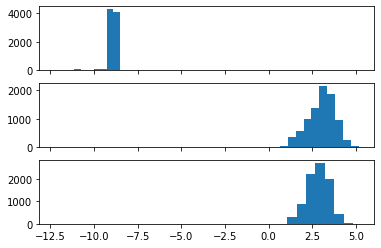

In [111]:
fig, axes = plt.subplots(3,1, sharex=True)
axes[0].hist(unc_model._broadcast_to_n_weights(unc_model.log_prior_scale.detach().cpu()))
axes[1].hist(gp_reg_unc_model._broadcast_to_n_weights(gp_reg_unc_model.log_prior_scale.detach().cpu()))
axes[2].hist(gp_reg_unc_model_2._broadcast_to_n_weights(gp_reg_unc_model_2.log_prior_scale.detach().cpu()))
